In [ ]:
import numpy as np
import circe as ci
import scanpy as sc
import scipy as sp


In [ ]:
adata = sc.read_h5ad("/data2st1/junyi/output/motif/HIP_Astro-Epen.h5ads")

In [ ]:
adata.obs

In [ ]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)


In [ ]:
adata.var.index=adata.var.index.str.replace(":", "_").str.replace("-", "_")

In [ ]:
adata = ci.add_region_infos(adata)


In [ ]:
adata

In [ ]:
ci.compute_atac_network(
    adata, #metacells,
    organism="mouse",
)

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
final_score = ci.sliding_graphical_lasso(
    adata,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=500,
    verbose=True
)
adata.varp['atac_network'] = final_score


Alpha coefficient calculated : 0.00203203854603641


Averaging co-accessibility scores across windows...
Done !


In [50]:
adata.varp['atac_network']

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2081903 stored elements and shape (84490, 84490)>

In [30]:
circe_network = ci.extract_atac_links(adata) #metacells)
circe_network.head(10)


,Peak1,Peak2,score
0,chr2_172499315_172499816,chr2_172505883_172506384,0.747871
1,chr8_64319939_64320440,chr8_64320572_64321073,0.715872
2,chr2_98492390_98492891,chr2_98497260_98497761,0.708827
3,chr13_24788049_24788550,chr13_25028487_25028988,0.700374
4,chr2_98496429_98496930,chr2_98497260_98497761,0.691031
5,chr1_98089258_98089759,chr1_98089805_98090306,0.682500
6,chr6_92713323_92713824,chr6_92901159_92901660,0.666357
7,chr2_98492390_98492891,chr2_98496429_98496930,0.664358
8,chr13_72330635_72331136,chr13_72335959_72336460,0.652149
9,chr13_109252804_109253305,chr13_109253306_109253807,0.647897


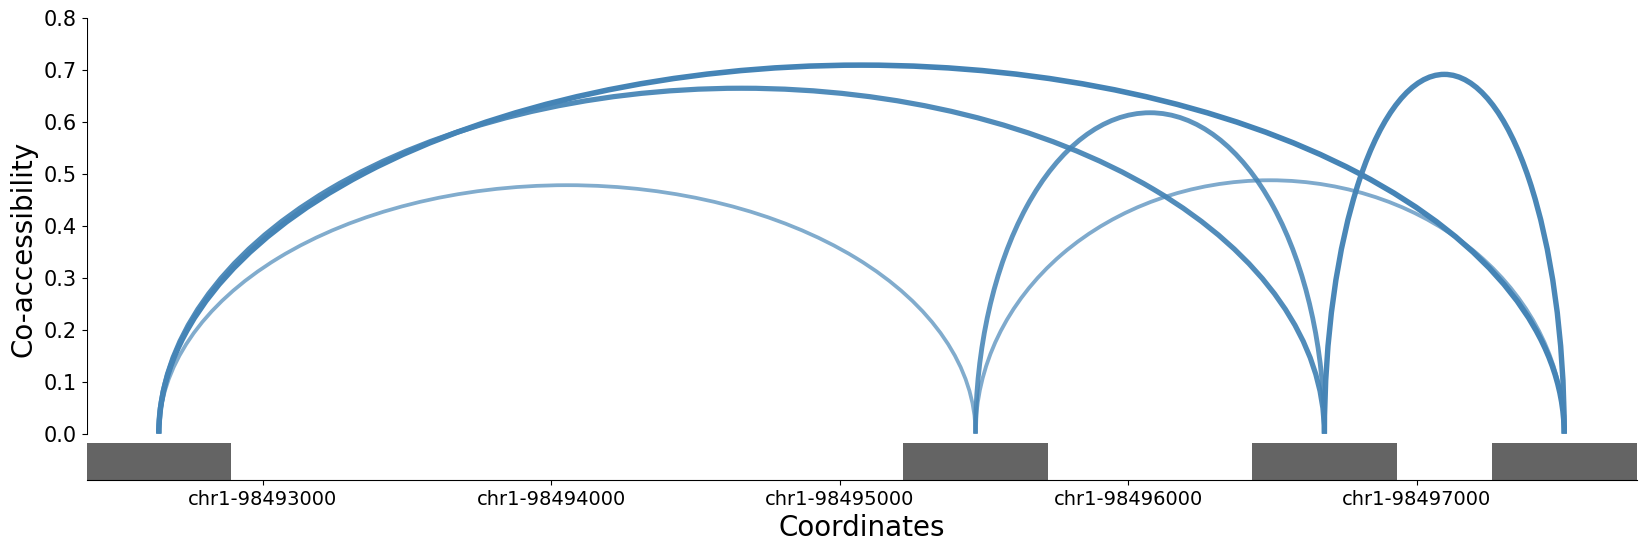

In [ ]:
ci.plot_connections(
    circe_network,
    chromosome="chr2",
    start=98000000,
    end=99000000,
    sep=("_","_"),
    abs_threshold=0.01
)

In [34]:
ccans = ci.find_ccans(circe_network, seed=0)


Coaccessibility cutoff used: 0.07
Number of CCANs generated: 2766


In [49]:
ccans

,Peak,CCAN
0,chr2_98492390_98492891,1
1,chr2_98495220_98495721,1
2,chr2_98496429_98496930,1
3,chr2_98497260_98497761,1
4,chr17_40156623_40157124,5
...,...,...
23254,chrX_165023679_165024180,6958
23255,chrX_165021691_165022192,6958
23256,chr3_122896809_122897310,7028
23257,chr3_122717647_122718148,7028


In [36]:
adata = ci.add_ccans(adata)


Coaccessibility cutoff used: 0.07


In [37]:
adata.var.head()


,n_cells,chromosome,start,end,CCAN
chr1_3050185_3050686,10,chr1,3050185,3050686,None
chr1_3364342_3364843,5,chr1,3364342,3364843,None
chr1_3741764_3742265,26,chr1,3741764,3742265,None
chr1_4482624_4483125,9,chr1,4482624,4483125,None
chr1_4563621_4564122,15,chr1,4563621,4564122,1


In [47]:
adata.var['CCAN']['chr2_98492390_98492891']


2742

This CCAN module is on the chromosome: chr2


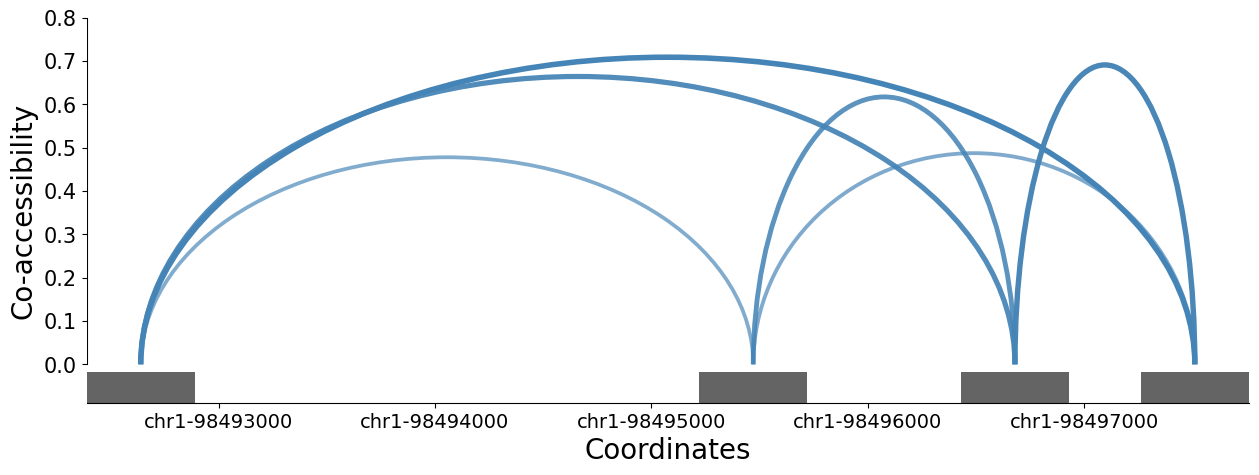

In [48]:
ax = ci.draw.plot_ccan(
    adata,
    ccan_module=2742,
    sep=('_', '_'),
    abs_threshold=0,
    figsize=(15,5),
    only_positive=True)

In [41]:
ax